Do stworzenia rankingu cech wykorzystaliśmy biblioteki numpy, pandas oraz scilearn. Biblioteka numpy pozwoliła nam złączyć załadowane pliki w jedną listę, pandas - służyła głównie do ładnej prezentacji danych, a scilearn umożliwiła wyznaczenie rankingu cech pod względem ich przydatności do klasyfikacji.

In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import chi2
%matplotlib notebook

Stworzyliśmy również własne funkcje, które odpowiadają za załadowanie danych z plików.

In [3]:
from data_parser import load_features_names, load_all_files, load_data, load_diseases_names
from data_summary import show_distribution

Poniżej wykorzystywane funkcje pozwoliły nam załadować wszystkie dane z plików. *load_all_files()* pobierała informacje o cechach osobników z plików *inne.txt, ang_prect.txt, ang_prct_2.txt, mi.txt oraz mi_np.txt*. *load_features_names()* oraz *load_diseases_names()* pobierały odpowiednio nazwy cech oraz chorób z pliku *MYOCARDIAL INFRACTION DIAGNOSIS*, którego format, dla wygodniejszego przetwarzania, zmieniliśmy ręcznie na *.txt*.

In [4]:
datasets = load_all_files()
features_names = load_features_names()
diseases_names = load_diseases_names()

Funkcja *load_data()* rozdziela załadowane pliki na listy po to, abyśmy byli w stanie wypisać liczebność każdej z klas przy użyciu *print_classes_strength()*. Następnie wyświetlamy diagram kołowy przedstawiający zależności między liczebnościami poszczególnych klas.

                Pain of non heart origin: 230
                        Angina prectoris: 142
    Angina prectoris - Prinzmetal variant: 68
      Myocardial infraction (transmural): 263
  Myocardial infraction (subendocardial): 198


<IPython.core.display.Javascript object>


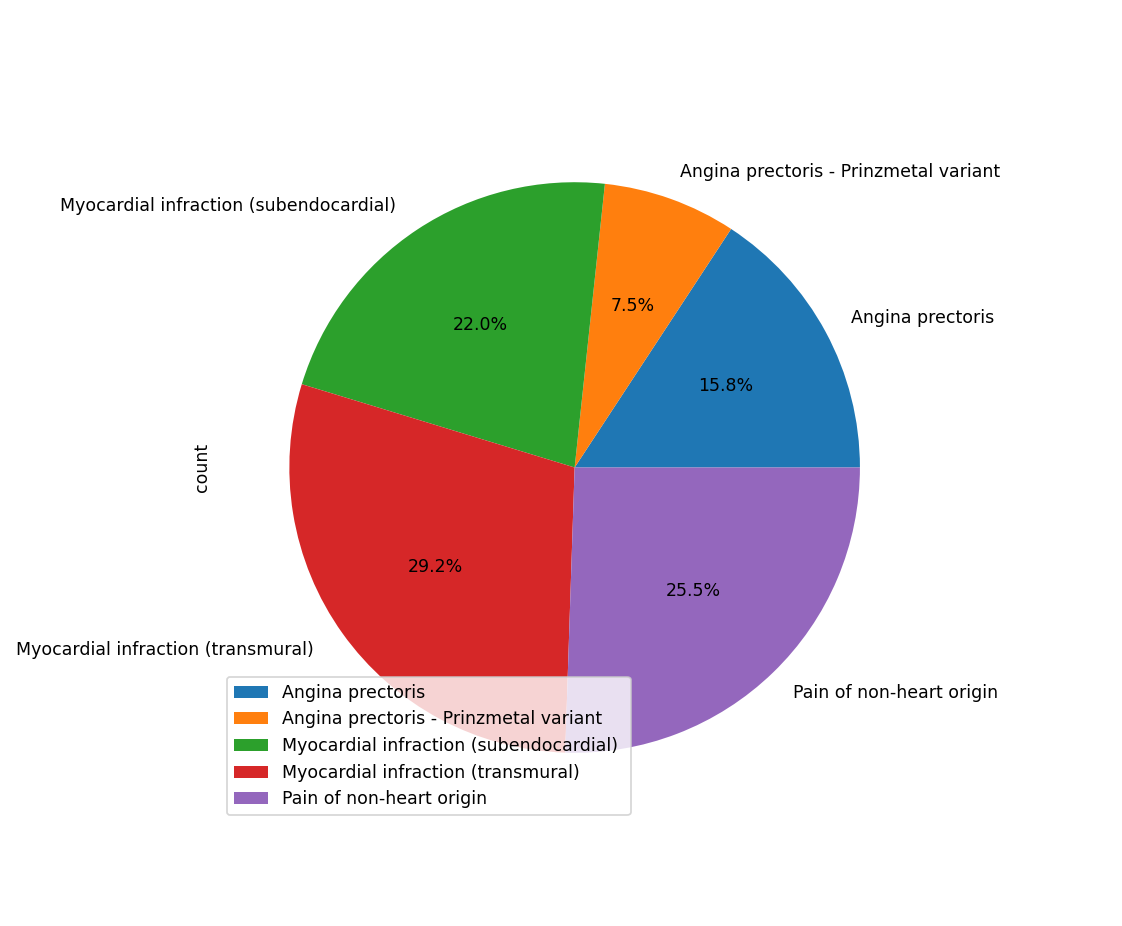

In [5]:
data = load_data(datasets)
data.print_classes_strength()

show_distribution(datasets, features_names)

Przygotowanie do wyznaczenia rankingu cech polegało na przygotowaniu dwóch list - *features*, będącą złączoną listą wszystkich cech poszczególnych osobników oraz *classes* zawierającą nazwy chorób, zachowując przy tym informacje o tym, której klasie (chorobie) odpowiadają konkretne wartości cech (wykorzystywany jest ten sam indeks).

In [5]:
features = np.concatenate([*datasets])
classes = np.concatenate(
    [np.full(dataset.shape[0], diseases_names[index]) for (index, dataset) in enumerate(datasets)])

Test *chi2* jest wykorzystywany w statystyce do sprawdzenia niezależności dwóch wydarzeń.

Wartość *chi2* wyrażona jest wzorem:

Przy tworzeniu rankingu cech chcemy zdeterminować związek pomiędzy niezależną cechą (np. płeć) oraz klasą (np. zawał serca). Jeśli parametry te są od siebie niezależne, to obserwowana wartość *O* jest bliska oczekiwanej wartości *E*, więc wartość *chi2* jest mała. 

Hipoteza zerowa zakłada, że cecha i klasa są od siebie niezależne.

Im większa wartość *chi2*, tym większa zależność między cechą i klasą, więc cechę tą możemy uznać za bardziej istotną dla naszego problemu. 

W dalszej części przedstawimy przyjęty przez nas poziom istotności, który pozwoli nam stwierdzić, dla których cech jesteśmy w stanie odrzucić hipotezę zerową, a tym samym założyć, że istnieje związek między cechą, a klasą.

In [6]:
scores, p_values = chi2(features, classes)

Po otrzymaniu wartości statystyki *chi2* oraz prawdopodobieństwa *p_value*, w celu ładnego wyświetlenia danych, korzystając z biblioteki *pandas*, utworzyliśmy jeden wspólny *DataFrame*, w którym dodaliśmy podpisy kolumn. Indeks został podniesiony o 1 po to, aby był on zgodny z indeksem występującym przy nazwie cechy w pliku *MYOCARDIAL INFRACTION DIAGNOSIS.doc*.

Następnie wyświetlamy otrzymane dane, zaokrąglając wartości do trzech miejsc dziesiętnych oraz sortując je malejąco po wartościach statystyki *chi2*.

In [7]:
features_with_values = pd.concat(
    [pd.DataFrame(features_names, columns=['Features']), pd.DataFrame(scores, columns=['Scores']),
     pd.DataFrame(p_values, columns=['P_values'])], axis=1)
features_with_values.index += 1  # To match with feature's number

print(features_with_values.sort_values('Scores', ascending=False).round(3))

                                  Features    Scores  P_values
36                 Systolic blood pressure  1980.235     0.000
7              Number of hours since onset   978.578     0.000
3                            Pain location   340.518     0.000
54               New ST segment depression   223.468     0.000
50                              New Q wave   200.256     0.000
56                    New T wave inversion   193.398     0.000
52                New ST segment elevation   188.224     0.000
55               Any ST segment depression   177.000     0.000
58  New intraventricular conduction defect   159.892     0.000
57                    Any T wave inversion   151.672     0.000
39                        Respiration rate   120.295     0.000
44                        Diastolic murmur   117.165     0.000
59  Any intraventricular conduction defect   117.095     0.000
22                  Prior angina prectoris   116.643     0.000
4                     Chest pain radiation   114.724   

Przyjęty przez nas poziom istotności *alpha* to 0.05. Wynika z tego, że nie odrzucamy hipotezy zerowej dla cech *Diaphoresis* oraz *Diuretics*, a tym samym utrzymujemy, że zależność cecha-klasa dla tych przypadków nie występuje. Przedstawione rozumowanie pozwala nam usunąć te dwie cechy z listy.

Ranking cech po opisanej wyżej modyfikacji został przedstawiony poniżej.

In [8]:
alpha = 0.05
for index, row in features_with_values.iterrows():
    p_value = row['P_values']
    if p_value > alpha:
        features_with_values.drop(index, inplace=True)
        
print(features_with_values.sort_values('Scores', ascending=False).round(3))

                                  Features    Scores  P_values
36                 Systolic blood pressure  1980.235     0.000
7              Number of hours since onset   978.578     0.000
3                            Pain location   340.518     0.000
54               New ST segment depression   223.468     0.000
50                              New Q wave   200.256     0.000
56                    New T wave inversion   193.398     0.000
52                New ST segment elevation   188.224     0.000
55               Any ST segment depression   177.000     0.000
58  New intraventricular conduction defect   159.892     0.000
57                    Any T wave inversion   151.672     0.000
39                        Respiration rate   120.295     0.000
44                        Diastolic murmur   117.165     0.000
59  Any intraventricular conduction defect   117.095     0.000
22                  Prior angina prectoris   116.643     0.000
4                     Chest pain radiation   114.724   